# Data Questions - Answered
Using Python with Jupyter Notebook

by: __Khairil Azmi Ashari__ - Intek Data Scientist

***

Install Needed packages here, get rid of '#'

In [1]:
from platform import python_version
print(python_version())

3.10.6


In [2]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      1.3.0
adagio                       0.2.4
amqp                         5.1.1
antlr4-python3-runtime       4.11.1
anyio                        3.6.1
appdirs                      1.4.4
APScheduler                  3.9.1
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asgiref                      3.5.2
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        21.4.0
Babel                        2.10.3
backcall                     0.2.0
basemap                      1.3.4
basemap-data                 1.3.2
basemap-data-hires           1.3.2
beautifulsoup4               4.11.1
billiard                     3.6.4.0
bleach                       5.0.1
branca                       0.5.0
Brotli                       1.0.9
CacheControl                 0.12.11
cachetools                   5.2.0

In [3]:
# install all needed packages if not already installed
# !pip install mysql
# !pip install pandas
# !pip install duckdb
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install folium

# You Need to install this package to using geopandas
# !pip install pipwin
# !pipwin install gdal
# !pipwin install fiona
# !pip install geopandas

First We Need To Connect To Database and get All Data From Response Table and store it to response_df

In [51]:
# Initialize database dict
conn_params_dic = {
    'host': 'db-mysql-sgp1-90709-do-user-12808653-0.b.db.ondigitalocean.com',
    'user': 'intek_admin',
    'password': 'AVNS_DReg4Yip3xuEzfuYEbX',
    'database': 'ikata',
    'port': '25060'
}

#Connect to database function
import mysql.connector as mysql
from mysql.connector import Error

def connect(conn_params_dic):
    conn = None
    try:
        print('Connecting to the MySQL.....')
        conn = mysql.connect(**conn_params_dic)
        print('Connection succesfully.....')
        
    except Error as err:
        print('Error while connecting to Mysql ', err)
        # set the connection to 'None in case' in case of error
        conn = None
    return conn

mydb = connect(conn_params_dic)

import pandas as pd

query = "SELECT * FROM responses;"
df = pd.read_sql(query, mydb)
mydb.close()

Connecting to the MySQL.....
Connection succesfully.....


C:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Run Needed Function to do visualisation, etc

In [52]:
from folium.plugins import MarkerCluster
from matplotlib import pyplot as plt
from geopandas.tools import sjoin
import geopandas as gpd
import seaborn as sns
import folium, duckdb
import pandas as pd
import numpy as np


# Function needed to show graphic
def show_graph(df, x, y, x_rotate, title, xlabel, ylabel, fmt, sort):
    plt.figure(figsize=(15,5))
    if sort:
        df_sort = df.sort_values(by=sort, ascending=False)
        plot_order = df_sort[x].values
        ax = sns.barplot(data=df, x=x, y=y, order=plot_order)
    else:
        ax = sns.barplot(data=df, x=x, y=y)
    
    if isinstance(fmt, pd.Series) == True :
        ax.bar_label(ax.containers[0], labels=fmt)
    else:
        if fmt == False:
            ax.bar_label(ax.containers[0])
        else:
            ax.bar_label(ax.containers[0], fmt=fmt)

    # Rotate x ticks label if user_ids override each other 
    plt.xticks(rotation=x_rotate)
    plt.title(title, bbox={'facecolor':'0.8', 'pad':3})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)
    plt.show()
    
# Function needed to show map
def show_map(q, loc_data, arg1, arg2):
    marker_cluster = MarkerCluster()
    
    open_map = folium.Map(tiles='openstreetmap')
    open_map.add_child(marker_cluster)

    for lat, long, x, y in q:
        coordinate = [lat,long]
        folium.map.Marker(
            coordinate,
            icon=None,
            popup=arg1+': '+str(x)+', '+arg2+': '+str(y)
        ).add_to(marker_cluster)

    south_west_corner = min(loc_data)
    north_east_corner = max(loc_data)
    open_map.fit_bounds([south_west_corner, north_east_corner])

    display(open_map)

# Function to load file to GeoDataFrame
def load_file_to_gdf(import_filename):
    data = gpd.read_file(import_filename) 
    
    return data

# Function to cleaned & preprocesses kecamatan broder
def preprocess_gdf(file):
    # Load kecamatan shape file to gdf
    gdf = load_file_to_gdf(file)
    # Drop NaN and None
    gdf = gdf.replace(to_replace='None', value=np.nan).dropna()
    # For use only Aceh and SUMUT
    # gdf = gdf.query('Provinsi.str.contains("ACEH") or Provinsi.str.contains("SUMATERA UTARA")' , engine='python')
    # Drop unnecessery column
    gdf = gdf.drop(['No','Objek','Kode_Kab','Kode_Kec'], axis=1)
    # Rearrange column
    gdf = gdf[['Kecamatan','Kab_Kota','Provinsi','geometry']]
    # Rename column
    gdf.rename(columns = {'Kecamatan':'sdistrict','Kab_Kota':'district','Provinsi':'province'}, inplace=True)
    
    return gdf

# Function to map point to its respective sub district (Kecamatan)
def mapping_point(data, sdistrict_gdf, arg1,arg2, arg3):
    gdf = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.longitude, data.latitude))
    gdf.drop(['latitude', 'longitude'], axis=1, inplace=True)
    gdf.crs = "EPSG:4326" #Convert GEoDataFrame to crs

    # Determine point on village
    point_in_district = sjoin(gdf, sdistrict_gdf, predicate='within', how='inner' )
    gdf_sorted = point_in_district.sort_values('index_right')

    gdf_sorted.drop(['geometry','index_right','district','province'], axis=1, inplace=True)
    sorted_df = pd.DataFrame(gdf_sorted)
    
    # group by sdistrict
    result = duckdb.query("SELECT "+arg1+"("+arg2+") AS '"+arg3+"', sdistrict FROM sorted_df GROUP BY sdistrict;").df()
    result = sdistrict_gdf.merge(result, on = 'sdistrict')
    
    return result

# Function to process and show heat map
def show_heatMap(data, legend_name,arg1):
    # create a numpy array of length 6 and has linear spacing from the minimum total user to the maximum total user
    threshold_scale = np.linspace(data[arg1].min(),
                                  data[arg1].max(),
                                  6, dtype=int)
    threshold_scale = threshold_scale.tolist() # change the numpy array to a list
    threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

    # create a plain aceh sumut map
    heat_map = folium.Map(tiles='cartodbpositron', name='light mode', location=[3.352913, 97.913223], zoom_start=9)
    folium.Choropleth(
        geo_data = data,
        data = data,
        columns = ['sdistrict', arg1],
        key_on='feature.properties.sdistrict',
        fill_color='YlGnBu', 
        fill_opacity=0.5, 
        line_opacity=0.2,
        legend_name=legend_name,
        nan_fill_color='white',
        nan_fill_opacity=0.5,
        highlight=True,
        reset=True,
        smooth_factor=0,
        overlay=True,
        show=True,
        name=arg1
    ).add_to(heat_map)

    # Add hover functionallity.
    style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.1, 'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1}
    NIL = folium.features.GeoJson(
        data = data,
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function, 
        tooltip=folium.features.GeoJsonTooltip(
            fields=['sdistrict','district','province',arg1],
            aliases=['Kecamatan :','Kabupaten :','Provinsi :', arg1+' :'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
    )
    heat_map.add_child(NIL)
    heat_map.keep_in_front(NIL)


    # Add street map mode
    folium.TileLayer('openstreetmap', name='street map', control=True).add_to(heat_map)

    folium.LayerControl(collapsed=True).add_to(heat_map)
    display(heat_map)

    
# Convert dataframe to CSV
def print_csv(data, filename):
    data.to_csv(filename+'.csv', sep=';', index=False)
    print('Data '+filename+' Printed to CSV')

***
# 1. How many responses per day per user?

In [53]:
q1_df = duckdb.query("SELECT user_id, COUNT(*) AS 'total_response', COUNT(DISTINCT(strftime(datetime, '%d-%m-%Y'))) AS 'day_of_use', FROM df WHERE response <> '/skip' GROUP BY user_id").df()
q1_df['average_response_per_day'] = round(q1_df['total_response']/q1_df['day_of_use'], 2)
q1_df = q1_df.sort_values('average_response_per_day', ascending=False)
q1_df.head()

,user_id,total_response,day_of_use,average_response_per_day
35,0,461,3,153.67
26,249,542,10,54.20
3,214,1366,26,52.54
2,204,41,1,41.00
8,201,35,1,35.00


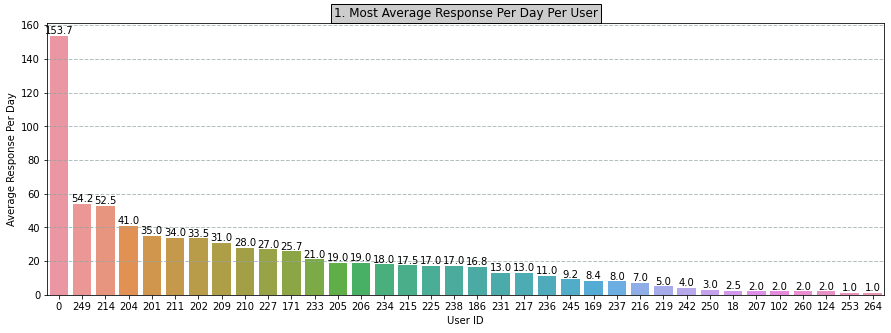

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns

x = 'user_id'
y = 'average_response_per_day'
title = '1. Most Average Response Per Day Per User'
xlabel = 'User ID'
ylabel = 'Average Response Per Day'
fmt='%.1f'

show_graph(q1_df, x, y, 0, title, xlabel, ylabel, fmt, y)

***
# 2. Percentage of skipped Responses from each data id?

In [55]:
q2_df = duckdb.query("SELECT data_id, COUNT(IF(response = '/skip',1,NULL)) AS 'total_skipped', Count(*) AS 'total' FROM df GROUP BY data_id ORDER BY data_id;").df()
q2_df['percentage'] = round(q2_df['total_skipped']/q2_df['total'] * 100, 2)
q2_df = q2_df.sort_values('percentage', ascending=False)
q2_df

,data_id,total_skipped,total,percentage
1,2,29,103,28.16
2,3,92,1016,9.06
0,1,240,3200,7.50


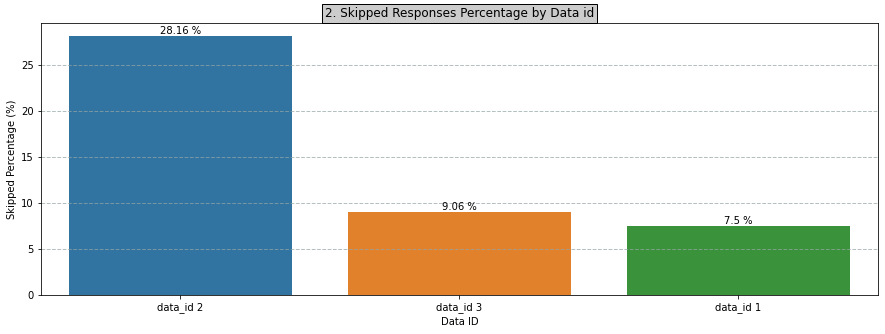

In [56]:
x = 'data_id ' + q2_df['data_id'].map(str)
y = 'percentage'
title = '2. Skipped Responses Percentage by Data id'
xlabel = 'Data ID'
ylabel = 'Skipped Percentage (%)'
fmt='%g %%'

show_graph(q2_df, x, y, 0, title, xlabel, ylabel, fmt, False)

***
# 3. Are certain prompt_id's skipped more?

In [57]:
q3_df = duckdb.query("SELECT prompt_id, count(*) AS 'total_skipped' FROM df WHERE response = '/skip' GROUP BY prompt_id ORDER BY count(*) DESC;").df()
q3_df.drop(q3_df.loc[q3_df['total_skipped']==1].index, inplace=True)
q3_df.head()

,prompt_id,total_skipped
0,1527,3
1,1534,3
2,285996,3
3,1508,3
4,20520,2


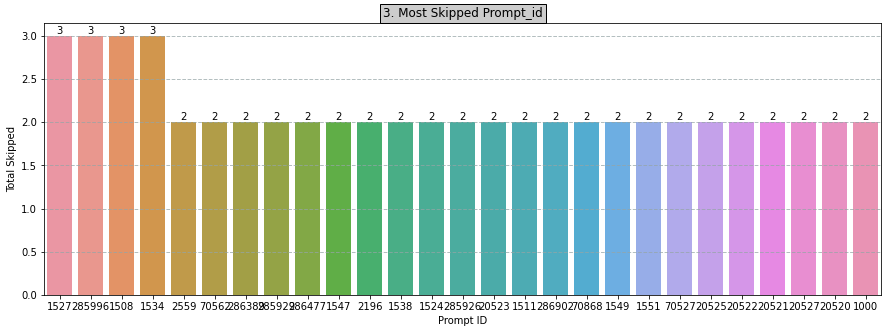

In [58]:
x = 'prompt_id'
y = 'total_skipped'
title = '3. Most Skipped Prompt_id'
xlabel = 'Prompt ID'
ylabel = 'Total Skipped'

show_graph(q3_df, x, y, 0, title, xlabel, ylabel, False, y)

***
# 4. Are certain response_id's skipped more?

In [59]:
q4_df = duckdb.query("SELECT response_id, count(*) AS 'total_skipped' FROM df WHERE Confirmed = 'skip' GROUP BY response_id ORDER BY 'total_skipped' DESC LIMIT 10;").df()
q4_df.head()

,response_id,total_skipped
0,639,1
1,642,1
2,643,1
3,644,1
4,645,1


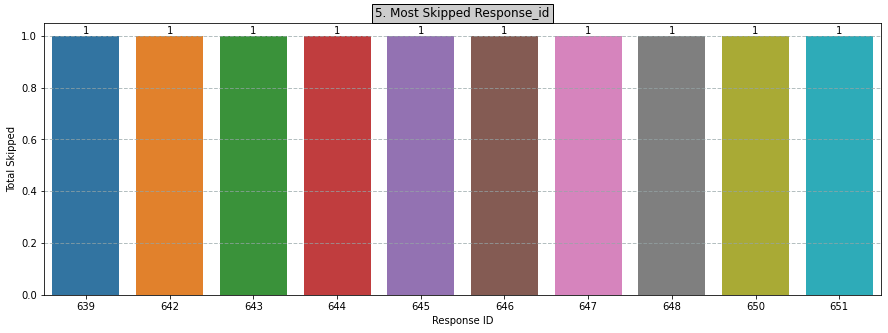

In [60]:
x = 'response_id'
y = 'total_skipped'
title = '5. Most Skipped Response_id'
xlabel = 'Response ID'
ylabel = 'Total Skipped'

show_graph(q4_df, x, y, 0, title, xlabel, ylabel, False, y)

***
# 5. How much Data Per Day is Each User Checking

In [61]:
q5_df = duckdb.query("SELECT user_id, count(*) AS 'total_check', COUNT(DISTINCT(strftime(datetime, '%d-%m-%Y'))) AS 'checking_days' FROM df WHERE check_id <> 0 GROUP BY user_id;").df()
q5_df['average_checking_per_day'] = round(q5_df['total_check']/q5_df['checking_days'], 2)
q5_df = q5_df.sort_values('average_checking_per_day', ascending=False)
q5_df.head()

,user_id,total_check,checking_days,average_checking_per_day
12,249,349,9,38.78
21,171,229,6,38.17
11,202,46,2,23.00
7,214,306,14,21.86
17,209,123,9,13.67


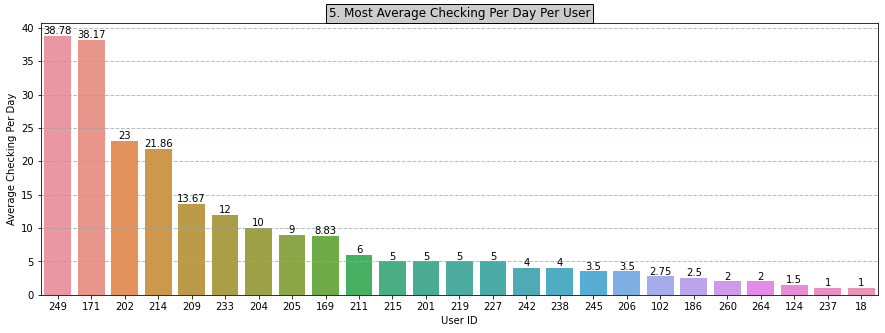

In [62]:
x = 'user_id'
y = 'average_checking_per_day'
title = '5. Most Average Checking Per Day Per User'
xlabel = 'User ID'
ylabel = 'Average Checking Per Day'

show_graph(q5_df, x, y, 0, title, xlabel, ylabel, False, y)

***
# 6. Percentage of User Who Had Most 'no' Confirmed?

In [63]:
q6_df = duckdb.query("SELECT user_id, COUNT(IF(Confirmed='no',1,NULL)) AS 'total_no_confirmed', COUNT(response) AS 'total_response' FROM df GROUP BY user_id;").df()
q6_df['no_confirmed_percentage'] = round(q6_df['total_no_confirmed']/q6_df['total_response'] * 100, 2)
q6_df = q6_df.sort_values('no_confirmed_percentage', ascending=False)
q6_df.drop(q6_df.loc[q6_df['no_confirmed_percentage']==0].index, inplace=True)
q6_df.head()

,user_id,total_no_confirmed,total_response,no_confirmed_percentage
36,260,1,2,50.00
29,233,8,24,33.33
5,214,371,1366,27.16
31,238,8,34,23.53
3,124,3,13,23.08


In [64]:
q6_df.dtypes

user_id                      int64
total_no_confirmed           int64
total_response               int64
no_confirmed_percentage    float64
dtype: object

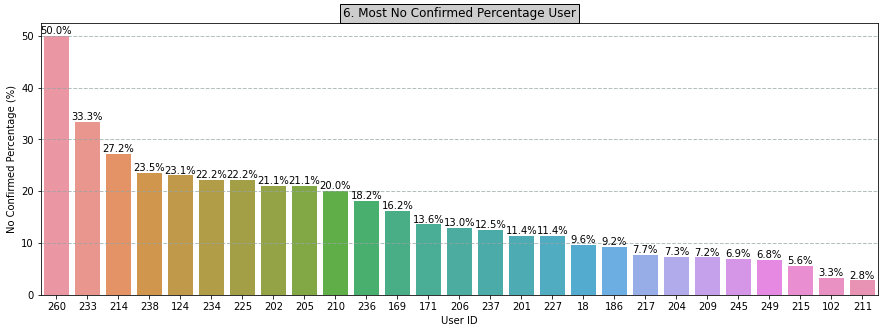

In [65]:
x = 'user_id'
y = 'no_confirmed_percentage'
title = '6. Most No Confirmed Percentage User'
xlabel = 'User ID'
ylabel = 'No Confirmed Percentage (%)'
fmt = '%.1f%%'

show_graph(q6_df, x, y, 0, title, xlabel, ylabel, fmt, y)

***
# 7. Where are Users Using The App From?

## 7.1 Based on Unique Location

In [66]:
q71_df = duckdb.query("SELECT latitude, longitude, count(distinct(user_id)) AS 'total_user', count(response) AS 'total_response' FROM df WHERE latitude AND longitude IS NOT NULL AND response <> '/skip' GROUP BY latitude, longitude;").df()
q71_df.head()

,latitude,longitude,total_user,total_response
0,3.459459,97.835940,6,93
1,3.513514,97.805459,3,230
2,3.459459,97.817889,6,68
3,3.477477,97.819753,7,125
4,3.477477,97.837805,1,4


In [67]:
q71_df.dtypes

latitude          float64
longitude         float64
total_user          int64
total_response      int64
dtype: object

In [68]:
q71 = zip(q71_df.latitude, q71_df.longitude, q71_df.total_user, q71_df.total_response)
loc_data = q71_df[['latitude','longitude']].values.tolist()
arg1 = 'total_user'
arg2 = 'total_response'

show_map(q71, loc_data, arg1, arg2)

***
## 7.2 Based on User_id Unique Location

In [69]:
q72_df = duckdb.query("SELECT user_id, latitude, longitude, count(response) AS 'total_response' FROM df WHERE latitude AND longitude IS NOT NULL AND response <> '/skip' GROUP BY user_id, latitude, longitude;").df()
q72_df.head()

,user_id,latitude,longitude,total_response
0,169,3.459459,97.835940,1
1,169,3.513514,97.805459,120
2,227,3.459459,97.817889,27
3,202,3.459459,97.835940,30
4,216,3.459459,97.817889,13


In [70]:
q72 = zip(q72_df.latitude, q72_df.longitude, q72_df.user_id, q72_df.total_response)
loc_data = q72_df[['latitude','longitude']].values.tolist()
arg1 = 'user_id'
arg2 = 'total_response'

show_map(q72, loc_data, arg1, arg2)

***
## 7.3 Based on Response Unique Location

In [71]:
q73_df = duckdb.query("SELECT user_id, response_id, latitude, longitude FROM df WHERE latitude AND longitude IS NOT NULL AND response <> '/skip';").df()
q73_df.head()

,user_id,response_id,latitude,longitude
0,169,826,3.459459,97.835940
1,169,893,3.513514,97.805459
2,169,894,3.513514,97.805459
3,227,1270,3.459459,97.817889
4,202,1271,3.459459,97.835940


In [72]:
q73 = zip(q73_df.latitude, q73_df.longitude, q73_df.response_id, q73_df.user_id)
loc_data = q73_df[['latitude','longitude']].values.tolist()
arg1 = 'response_id'
arg2 = 'user_id'

show_map(q73, loc_data, arg1, arg2)

***
## 7.4 Based on Check Data Unique Location

In [73]:
q74_df = duckdb.query("SELECT user_id, response_id, latitude, longitude FROM df WHERE check_id <> 0 AND Confirmed <> 'skip' AND latitude AND longitude IS NOT NULL;").df()
q74_df.head()

,user_id,response_id,latitude,longitude
0,169,826,3.459459,97.835940
1,169,893,3.513514,97.805459
2,169,894,3.513514,97.805459
3,205,1280,3.459459,97.835940
4,205,1287,3.459459,97.835940


In [74]:
q74 = zip(q74_df.latitude, q74_df.longitude, q74_df.response_id, q74_df.user_id)
loc_data = q74_df[['latitude','longitude']].values.tolist()
arg1 = 'check_data_id'
arg2 = 'user_id'

show_map(q74, loc_data, arg1, arg2)

***
## 7.5 User Count Each Sub District (Kecamatan) Heat Map

In [75]:
# Get Geometry Border of Kecamatan (Sub District)
indonesia_gdf = preprocess_gdf('batas_kecamatan')
q75_df = duckdb.query("SELECT latitude, longitude, count(distinct(user_id)) AS 'total_user' FROM df WHERE latitude AND longitude IS NOT NULL AND response <> '/skip' GROUP BY latitude, longitude;").df()
q75_final_df = mapping_point(q75_df, indonesia_gdf, 'SUM','total_user','total_user')
q75_final_df.tail()

,sdistrict,district,province,geometry,total_user
9,TANOH ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.84166 3.39943, 97.84201 3.39832, ...",1.0
10,MEDAN SUNGGAL,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.64658 3.59060, 98.64658 3.59054, ...",1.0
11,MEDAN PERJUANGAN,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.69375 3.61899, 98.69376 3.61894, ...",1.0
12,MEDAN TIMUR,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.69291 3.63975, 98.69293 3.63923, ...",1.0
13,MEDAN SELAYANG,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.65279 3.57648, 98.65277 3.57581, ...",5.0


In [76]:
show_heatMap(q75_final_df, 'Total User Each Sub District', 'total_user')

***
## 7.6 Response Count Each Sub District (Kecamatan) Heat Map

In [77]:
q76_df = duckdb.query("SELECT user_id, response_id, latitude, longitude FROM df WHERE latitude AND longitude IS NOT NULL AND response <> '/skip';").df()
q76_final_df = mapping_point(q76_df, indonesia_gdf, 'COUNT','response_id','total_response')
q76_final_df.tail()

,sdistrict,district,province,geometry,total_response
9,TANOH ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.84166 3.39943, 97.84201 3.39832, ...",15
10,MEDAN SUNGGAL,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.64658 3.59060, 98.64658 3.59054, ...",6
11,MEDAN PERJUANGAN,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.69375 3.61899, 98.69376 3.61894, ...",4
12,MEDAN TIMUR,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.69291 3.63975, 98.69293 3.63923, ...",19
13,MEDAN SELAYANG,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.65279 3.57648, 98.65277 3.57581, ...",86


In [78]:
show_heatMap(q76_final_df, 'Total Response Each Sub District', 'total_response')

***
## 7.7 Check Data Count Each Sub District (Kecamatan) Heat Map

In [79]:
q77_df = duckdb.query("SELECT user_id, response_id, latitude, longitude FROM df WHERE check_id <> 0 AND Confirmed <> 'skip' AND latitude AND longitude IS NOT NULL;").df()
q77_final_df = mapping_point(q77_df, indonesia_gdf, 'COUNT','response_id','total_check_data')
q77_final_df.tail()

,sdistrict,district,province,geometry,total_check_data
6,LAWE SUMUR,ACEH TENGGARA,ACEH,"POLYGON ((97.92117 3.49882, 97.92157 3.49813, ...",20
7,DARUL HASANAH,ACEH TENGGARA,ACEH,"POLYGON ((97.76447 3.56529, 97.76414 3.56203, ...",2
8,LAWE BULAN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91393 3.53056, ...",15
9,MEDAN PERJUANGAN,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.69375 3.61899, 98.69376 3.61894, ...",2
10,MEDAN SELAYANG,KOTA MEDAN,SUMATERA UTARA,"POLYGON ((98.65279 3.57648, 98.65277 3.57581, ...",4


In [80]:
show_heatMap(q77_final_df, 'Total Check Data Each Sub District', 'total_check_data')

***
# 8. Daily Active User Count?

In [81]:
q8_df = duckdb.query("SELECT DISTINCT(strftime(datetime, '%d-%m-%Y')) AS 'date', COUNT(DISTINCT(user_id)) AS 'total_user' FROM df GROUP BY strftime(datetime, '%d-%m-%Y');").df()
q8_df.head()

,date,total_user
0,13-08-2022,2
1,14-08-2022,1
2,16-08-2022,1
3,18-08-2022,1
4,29-08-2022,1


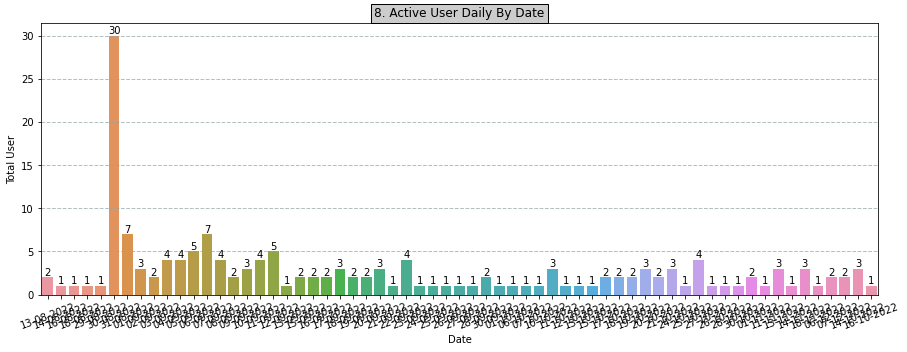

In [82]:
x = 'date'
y = 'total_user'
title = '8. Active User Daily By Date'
xlabel = 'Date'
ylabel = 'Total User'
x_degree = 20

show_graph(q8_df, x, y, x_degree, title, xlabel, ylabel, False, False)

***
# 9. Average of Daily Active User?

In [83]:
average_daily_user = q8_df['total_user'].mean()
print(str(round(average_daily_user, 2)) + ' user per day')

2.63 user per day


***
# 10. Daily Responses Count?

In [84]:
q10_df = duckdb.query("SELECT DISTINCT(strftime(datetime, '%d-%m-%Y')) AS 'date', COUNT(response) AS 'total_response' FROM df WHERE response <> '/skip' GROUP BY strftime(datetime, '%d-%m-%Y');").df()
q10_df.head()

,date,total_response
0,13-08-2022,15
1,14-08-2022,1
2,16-08-2022,1
3,18-08-2022,2
4,30-08-2022,513


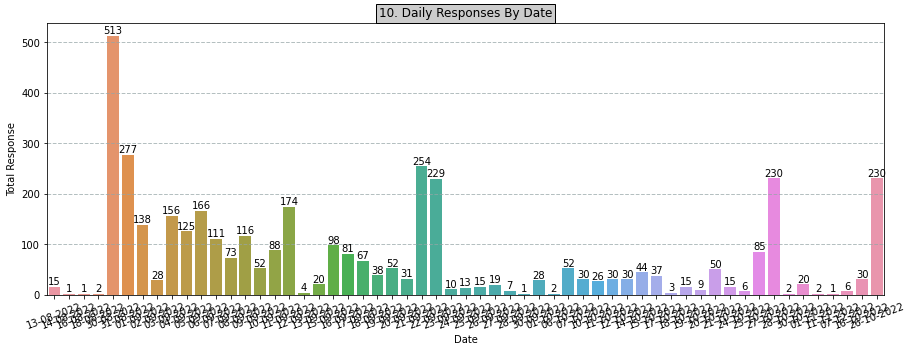

In [85]:
x = 'date'
y = 'total_response'
title = '10. Daily Responses By Date'
xlabel = 'Date'
ylabel = 'Total Response'
x_degree = 20

show_graph(q10_df, x, y, x_degree, title, xlabel, ylabel, False, False)

***
# 11. Average of Daily Responses?

In [86]:
average_responses = q10_df['total_response'].mean()
print(str(round(average_responses, 2)) + ' responses per day')

69.44 responses per day


***
# 12. Daily Check Data Count?

In [87]:
q12_df = duckdb.query("SELECT DISTINCT(strftime(datetime, '%d-%m-%Y')) AS 'date', COUNT(response) AS 'total_check_data' FROM df WHERE check_id <> 0 AND Confirmed <> 'skip' GROUP BY strftime(datetime, '%d-%m-%Y');").df()
q12_df.head()

,date,total_check_data
0,16-08-2022,1
1,18-08-2022,2
2,30-08-2022,78
3,31-08-2022,187
4,01-09-2022,76


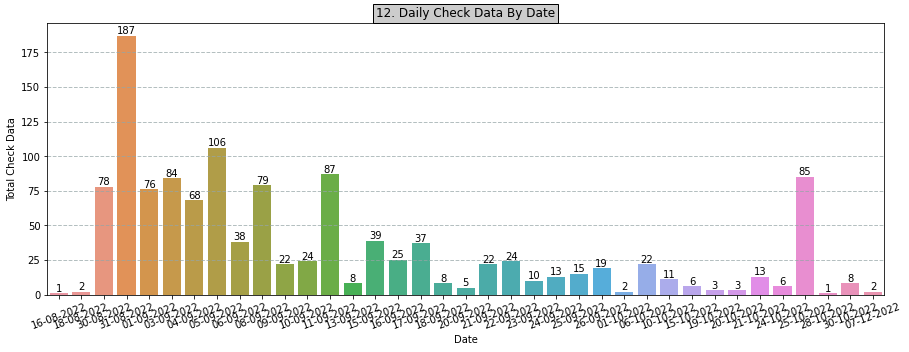

In [88]:
x = 'date'
y = 'total_check_data'
title = '12. Daily Check Data By Date'
xlabel = 'Date'
ylabel = 'Total Check Data'
x_degree = 20

show_graph(q12_df, x, y, x_degree, title, xlabel, ylabel, False, False)

***
# 13. Average of Daily Check Data?

In [89]:
average_check_data = q12_df['total_check_data'].mean()
print(str(round(average_check_data, 2)) + ' check data per day')

33.49 check data per day


***
# 14. Are they filling the survey out at one time or throughout the day? What times? How long is it taking?

How much session the have on each screen time (We assume they off screen time if they had more than 10 minutes interval between response)

In [90]:
# Get all column needed to gain session
q14_df = duckdb.query("SELECT user_id, strftime(datetime, '%d-%m-%Y') AS 'date' , datetime FROM df GROUP BY user_id, datetime ORDER BY user_id, datetime ;").df()

# Process on counting interval time and session count
from datetime import datetime, timedelta

# Creating interval column
intervalList = []
# Fill Session column with default value
q14_df['session'] = 1

for index in range(len(q14_df)):
    if((index < len(q14_df)-1) and (q14_df.at[index, 'user_id'] == q14_df.at[index+1, 'user_id']) and (q14_df.at[index, 'date'] == q14_df.at[index+1, 'date'])):
        interval = q14_df.at[index+1, 'datetime'] - q14_df.at[index, 'datetime']
        intervalList.append(interval)
        if(interval > timedelta(minutes=10)):
            q14_df.at[index+1, 'session'] = q14_df.at[index, 'session'] + 1
        else:
            q14_df.at[index+1, 'session'] = q14_df.at[index, 'session']
    else:
        intervalList.append(timedelta(seconds=0))
q14_df['interval'] = intervalList

# Showing list info from highest session

session_df = duckdb.query("SELECT user_id, date, session, min(datetime) AS 'min_datetime', max(datetime) AS 'max_datetime', age(max(datetime), min(datetime)) AS 'session_time' FROM q14_df GROUP BY user_id, date, session ORDER BY session_time DESC LIMIT 20;").df()
session_df.head()

,user_id,date,session,min_datetime,max_datetime,session_time
0,214,21-09-2022,4,2022-09-21 13:04:49,2022-09-21 14:34:43,0 days 01:29:54
1,249,31-08-2022,2,2022-08-31 03:08:58,2022-08-31 04:05:48,0 days 00:56:50
2,171,11-09-2022,1,2022-09-11 07:26:30,2022-09-11 08:08:00,0 days 00:41:30
3,171,19-09-2022,1,2022-09-19 02:57:41,2022-09-19 03:32:33,0 days 00:34:52
4,204,30-08-2022,2,2022-08-30 03:19:03,2022-08-30 03:53:09,0 days 00:34:06


In [91]:
q14 = duckdb.query("SELECT user_id, strftime(datetime, '%d-%m-%Y') AS 'date' , datetime FROM df GROUP BY user_id, datetime ORDER BY user_id, datetime ;").df()
q14

,user_id,date,datetime
0,0,05-09-2022,2022-09-05 08:04:53
1,0,05-09-2022,2022-09-05 09:33:08
2,0,06-09-2022,2022-09-06 05:18:07
3,0,06-09-2022,2022-09-06 05:18:11
4,0,26-10-2022,2022-10-26 03:15:02
...,...,...,...
3986,260,10-10-2022,2022-10-10 05:38:14
3987,260,10-10-2022,2022-10-10 05:38:36
3988,264,14-10-2022,2022-10-14 05:35:32
3989,264,14-10-2022,2022-10-14 05:37:33


In [92]:
q14_df

,user_id,date,datetime,session,interval
0,0,05-09-2022,2022-09-05 08:04:53,1,0 days 01:28:15
1,0,05-09-2022,2022-09-05 09:33:08,2,0 days 00:00:00
2,0,06-09-2022,2022-09-06 05:18:07,1,0 days 00:00:04
3,0,06-09-2022,2022-09-06 05:18:11,1,0 days 00:00:00
4,0,26-10-2022,2022-10-26 03:15:02,1,0 days 00:00:02
...,...,...,...,...,...
3986,260,10-10-2022,2022-10-10 05:38:14,1,0 days 00:00:22
3987,260,10-10-2022,2022-10-10 05:38:36,1,0 days 00:00:00
3988,264,14-10-2022,2022-10-14 05:35:32,1,0 days 00:02:01
3989,264,14-10-2022,2022-10-14 05:37:33,1,0 days 00:10:17


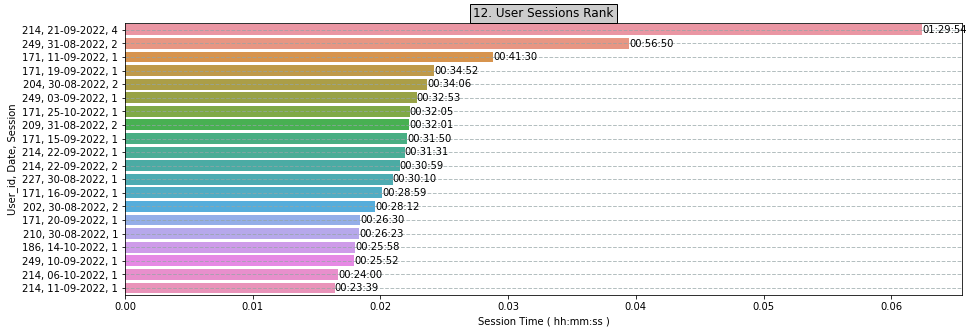

In [93]:
import matplotlib.dates as mdates

# Specify a date to use for the times
zero = datetime(1,1,1)
time = [zero + t for t in session_df['session_time']]

# Convert datetimes to numbers
zero = mdates.date2num(zero)
time = [t-zero for t in mdates.date2num(time)]

x= time
y = [str(x)+', '+str(y)+', '+str(z) for x,y,z in zip(session_df['user_id'], session_df['date'], session_df['session'])]
title = '12. User Sessions Rank'
xlabel = 'Session Time ( hh:mm:ss )'
ylabel = 'User_id, Date, Session'
custom_label = session_df['session_time'].astype(str).map(lambda x: x[7:])

show_graph(q6_df, x, y, 0, title, xlabel, ylabel, custom_label, False)

***
# 15. List of have not been confirmed Responses after check data

In [94]:
mydb = connect(conn_params_dic)

query2 = "SELECT  pr.prompt_id AS 'Prompt ID', pr.prompt AS 'Prompt', pr.hint AS 'Hint', rs.response_id as 'Response ID' , rs.response AS 'Response' FROM all_prompts AS pr, responses AS rs WHERE pr.prompt_id = rs.prompt_id AND rs.response_id IN (select check_id from responses WHERE check_id<>0 AND Confirmed='no') ORDER BY pr.prompt_id;"
manual_check_data_list = pd.read_sql(query2, mydb)
mydb.close()
manual_check_data_list.head()

Connecting to the MySQL.....
Connection succesfully.....


C:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Prompt ID,Prompt,Hint,Response ID,Response
0,337,Kata yang digunakan untuk menyebut proses ber...,surut,2974,sukhut
1,339,Kata yang digunakan untuk menyebut sisa endap...,endapan,2979,muke
2,1000,Kata umum yang digunakan untuk menyebut gangga...,ganggang laut,4771,Please leave the package by the door. Thanks! ...
3,1505,Kata yang digunakan untuk menyebut lebih dari...,penduduk,1441,khombongon kalak kute
4,1505,Kata yang digunakan untuk menyebut lebih dari...,penduduk,1452,khakyat


In [95]:
# Convert dataframe to CSV
print_csv(manual_check_data_list, 'manual_check_data_list')

Data manual_check_data_list Printed to CSV


***
# 16. List of confirmed Responses

In [96]:
mydb = connect(conn_params_dic)

query3 = "SELECT prompt_id, prompt, hint FROM all_prompts;"
prompt_df = pd.read_sql(query3, mydb)
mydb.close()
prompt_df.head()

Connecting to the MySQL.....
Connection succesfully.....


C:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,prompt_id,prompt,hint
0,1,segala sesuatu yang dapat kita lihat,alam semesta
1,2,segala sesuatu yang dapat kita lihat,ciptaan
2,3,Kata yang digunakan untuk menyebut segala sesu...,langit dan bumi
3,4,Kata yang digunakan untuk menyebut segala sesu...,segala sesuatu yang ada
4,5,Kata yang digunakan untuk menyebut langit.,langit


In [97]:
q16_df = duckdb.query("SELECT response_id, prompt_id, user_id, response, data_id, check_id, check_type FROM df WHERE Confirmed == 'yes';").df()
alas_df = duckdb.query("SELECT * FROM q16_df WHERE check_id = 0;").df()
indo_df = duckdb.query("SELECT * FROM q16_df WHERE check_id <> 0;").df()

sentences_join_df = duckdb.query("SELECT al.response_id, al.prompt_id, al.user_id, al.response, al.data_id, ind.response_id AS 'check_response_id', ind.user_id AS 'check_user_id', ind.response AS 'check_response', ind.check_type  FROM alas_df AS al INNER JOIN indo_df AS ind ON al.response_id = ind.check_id;").df()
final_join = duckdb.query("SELECT * FROM prompt_df AS pr INNER JOIN sentences_join_df AS sj ON pr.prompt_id = sj.prompt_id;").df()
final_join = final_join.drop('prompt_id_2', axis=1)

manual_df = duckdb.query("SELECT * FROM q16_df WHERE user_id = 0;").df()
manual_join_df = duckdb.query("SELECT * FROM prompt_df AS pr INNER JOIN manual_df AS mn ON pr.prompt_id = mn.prompt_id;").df()
manual_join_df = manual_join_df.drop(['prompt_id_2', 'check_id'], axis=1)

final_full_join = pd.concat([final_join, manual_join_df], ignore_index = True, sort = False)
final_full_join[['check_response_id', 'check_user_id']] = final_full_join[['check_response_id', 'check_user_id']].fillna(0).astype(np.int64)
final_full_join.head()

,prompt_id,prompt,hint,response_id,user_id,response,data_id,check_response_id,check_user_id,check_response,check_type
0,1474,Kata yang digunakan untuk menyebut pemimpin s...,pemimpin binatang,2951,209,pemimping binatang kane,1,3064,249,pemimpin hewan juga,dailyCheck
1,1480,Kata yang digunakan untuk menyebut binatang ja...,jantan,2982,249,boguh,1,3091,209,laki,dailyCheck
2,1481,Kata yang digunakan untuk menyebut binatang ja...,betina,3000,214,betine,1,3047,249,bAtinnya,dailyCheck
3,1484,Kata yang digunakan untuk menyebut dunia di se...,dunia,3009,214,dunie,1,3045,249,dunia,dailyCheck
4,1490,Kata yang digunakan untuk menyebut pelestaria...,pelestarian,2967,249,pelestakhien,1,3086,209,pelestarian,dailyCheck


In [98]:
word_list_confirmed = duckdb.query("SELECT * FROM final_full_join WHERE data_id = 1;").df()
word_list_confirmed = word_list_confirmed.drop('data_id', axis=1)
word_list_confirmed.head()

,prompt_id,prompt,hint,response_id,user_id,response,check_response_id,check_user_id,check_response,check_type
0,1474,Kata yang digunakan untuk menyebut pemimpin s...,pemimpin binatang,2951,209,pemimping binatang kane,3064,249,pemimpin hewan juga,dailyCheck
1,1480,Kata yang digunakan untuk menyebut binatang ja...,jantan,2982,249,boguh,3091,209,laki,dailyCheck
2,1481,Kata yang digunakan untuk menyebut binatang ja...,betina,3000,214,betine,3047,249,bAtinnya,dailyCheck
3,1484,Kata yang digunakan untuk menyebut dunia di se...,dunia,3009,214,dunie,3045,249,dunia,dailyCheck
4,1490,Kata yang digunakan untuk menyebut pelestaria...,pelestarian,2967,249,pelestakhien,3086,209,pelestarian,dailyCheck


In [99]:
sentences_list_confirmed = duckdb.query("SELECT * FROM final_full_join WHERE data_id <> 1;").df()
sentences_list_confirmed = sentences_list_confirmed.drop('hint', axis=1)
sentences_list_confirmed.head()

,prompt_id,prompt,response_id,user_id,response,data_id,check_response_id,check_user_id,check_response,check_type
0,70527,Raden Subantaka adalah anak Pangeran Martasari.,638,171,Raden Subantaka anak dakhi khaje Matasari,2,1296,205,Raden Subantaka anak dari rasa matasari,dailyCheck
1,70534,Penyakit disebabkan oleh rematik.,662,171,penakit nisebabken khematik,2,1282,204,penyakit di sebabkan rematik,dailyCheck
2,70527,Raden Subantaka adalah anak Pangeran Martasari.,638,171,Raden Subantaka anak dakhi khaje Matasari,2,1310,204,raden subantaka anak dari raja matasari,dailyCheck
3,70534,Penyakit disebabkan oleh rematik.,662,171,penakit nisebabken khematik,2,1332,219,penyakit di sebabkan rematik,dailyCheck
4,70527,Raden Subantaka adalah anak Pangeran Martasari.,638,171,Raden Subantaka anak dakhi khaje Matasari,2,1355,219,raden subantaka anak dari raja matasari,dailyCheck


In [100]:
# Convert dataframe to CSV
print_csv(sentences_list_confirmed, 'sentences_list_confirmed')

print_csv(word_list_confirmed, 'word_list_confirmed')

Data sentences_list_confirmed Printed to CSV
Data word_list_confirmed Printed to CSV
